#Model 3

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


df = pd.read_csv('DataFile_ML_All.csv')


df = df.drop(columns=['Date', 'id', 'station_code', 'Secchi Depth(m)', 'DO(mg/l)', 'Temperature (deg cels)', 'Salinity(ppt)','Depth(m)','DIN', 'Ammonium','pH', 'Turbidity(NTU)', 'Nitrate+Nitrite','Phosphate', 'N/P'])

In [2]:
df = df.drop(columns=['year', 'month', 'day', 'Julian Year','decimal year', 'sin(month)', 'cos(month)'])

In [3]:
X = df.drop('Chlorophyll-a (ug/l)', axis=1)
y = df['Chlorophyll-a (ug/l)'] # Target variable

In [4]:
# Perform an 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. XGBoost Regression Model

In [5]:
#Bayesian Optimization

In [6]:
from skopt import gp_minimize
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def objective_function(params):
    # Convert the parameter values to the appropriate type and range
    n_estimators, max_depth, learning_rate = params

    # Create an XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        random_state=42,
    )

    # Calculate the negative mean absolute error (we want to minimize it)
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    # Calculate the average MAE score
    avg_mae = mae_scores.mean()

    return avg_mae


from skopt.space import Integer, Real

space = [
    Integer(1, 200, name='n_estimators'),
    Integer(1, 20, name='max_depth'),
    Real(0.001, 0.1, name='learning_rate')
]


result = gp_minimize(objective_function, space, n_calls=10, random_state=42)

# The result variable will contain the optimal hyperparameters that minimize MAE
optimal_hyperparameters = result.x
optimal_mae = result.fun

# Print the best hyperparameters and corresponding MAE
print("Best Hyperparameters:")
for param, value in zip(space, optimal_hyperparameters):
    print(f"{param.name}: {value}")
print("Optimal MAE:", optimal_mae)

Best Hyperparameters:
n_estimators: 92
max_depth: 7
learning_rate: 0.01514381497427214
Optimal MAE: 3.4664415600299767


Mean MAE: 3.4259
Standard Deviation MAE: 0.4933


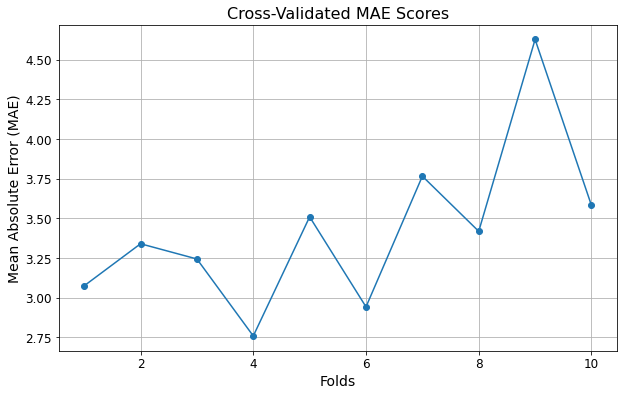

In [7]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Initialize and configure the XGBoost regression model
xgb_model = XGBRegressor(
    n_estimators=92,
    max_depth=7,
    learning_rate=0.01514381497427214,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -cv_scores  # Convert negative MAE scores to positive

# Calculate the mean and standard deviation of the MAE scores
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

print("Mean MAE: {:.4f}".format(mean_mae))
print("Standard Deviation MAE: {:.4f}".format(std_mae))

# Plot the cross-validation scores with larger fontsizes
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mae_scores, marker='o', linestyle='-')
plt.title("Cross-Validated MAE Scores", fontsize=16)  # Set title fontsize
plt.xlabel("Folds", fontsize=14)  # Set xlabel fontsize
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)  # Set ylabel fontsize
plt.xticks(fontsize=12)  # Set tick labels fontsize for x-axis
plt.yticks(fontsize=12)  # Set tick labels fontsize for y-axis
plt.grid(True)

# Save the plot as an image
plt.savefig('CV_XGBoostBayesian_03.jpeg')

# Show the plot
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Bayesian_03 = XGBRegressor(random_state=42, n_estimators=92, max_depth=7, learning_rate=0.01514381497427214)


    # Fit the model on the full training data
    xgb_model_Bayesian_03.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Bayesian_03.predict(X_train)
    y_test_pred = xgb_model_Bayesian_03.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.26977429737961595
Average Test R2: 0.1670995633995118
Average Train MSE: 19.66021579401605
Average Test MSE: 21.577194610730256
Average Train RMSE: 4.433984189644361
Average Test RMSE: 4.645125898264784
Average Train MAE: 2.875732798172754
Average Test MAE: 3.089941704291353
Average Train PBIAS: -6.091112285857252
Average Test PBIAS: -12.668588793538222


In [9]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Bayesian_03.pkl', 'wb') as file:
    pickle.dump(xgb_model_Bayesian_03, file)
    
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Bayesian_03, 'xgb_model_Bayesian_03.joblib')

['xgb_model_Bayesian_03.joblib']

In [ ]:
#Grid Search Optimization

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 140, 130, 150, 180],
    'max_depth': [2, 3 , 5, 7, 9],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
}

# Create an XGBoost model
model = XGBRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model with the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_hyperparameters = grid_search.best_params_
best_model = grid_search.best_estimator_

# Calculate the mean absolute error on the test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and MAE
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")
print(f"Mean Absolute Error: {mae}")

Best Hyperparameters:
learning_rate: 0.02
max_depth: 3
n_estimators: 80
Mean Absolute Error: 3.0187515430305396


In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Grid_03 = XGBRegressor(random_state=42, n_estimators=80, max_depth=3, learning_rate=0.02)


    # Fit the model on the full training data
    xgb_model_Grid_03.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Grid_03.predict(X_train)
    y_test_pred = xgb_model_Grid_03.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.25182569587326525
Average Test R2: 0.21118789440506927
Average Train MSE: 20.14345457560012
Average Test MSE: 20.435038290039714
Average Train RMSE: 4.488146006493126
Average Test RMSE: 4.520513056063407
Average Train MAE: 2.965405770806706
Average Test MAE: 3.0187515430305343
Average Train PBIAS: -26.475968989807196
Average Test PBIAS: -27.662121075418646


In [12]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Grid_03.pkl', 'wb') as file:
    pickle.dump(xgb_model_Grid_03, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Grid_03, 'xgb_model_Grid_03.joblib')

['xgb_model_Grid_03.joblib']

In [ ]:
#randomized search optimization

In [13]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter distributions
param_dist = {
    'n_estimators': [50, 60, 70, 80, 90, 100, 140, 130, 150, 180, 190],
    'max_depth': [2, 3 , 5, 7, 9],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
}

# Create an XGBoost model
model = XGBRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42)

# Fit the model with the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_hyperparameters = random_search.best_params_
best_model = random_search.best_estimator_

# Calculate the mean absolute error on the test set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and MAE
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")
print(f"Mean Absolute Error: {mae}")

Best Hyperparameters:
n_estimators: 60
max_depth: 3
learning_rate: 0.02
Mean Absolute Error: 3.1281932296317794


In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from xgboost import XGBRegressor


# Initialize lists to store the performance metrics over iterations
train_r2_values = []
test_r2_values = []
train_mse_values = []
test_mse_values = []
train_rmse_values = []
test_rmse_values = []
train_mae_values = []
test_mae_values = []
train_pbias_values = []
test_pbias_values = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create an XGBoost model
    xgb_model_Random_03 = XGBRegressor(random_state=42, n_estimators=60, max_depth=3, learning_rate=0.02)


    # Fit the model on the full training data
    xgb_model_Random_03.fit(X_train, y_train)

    # Make predictions on both training and test data
    y_train_pred = xgb_model_Random_03.predict(X_train)
    y_test_pred = xgb_model_Random_03.predict(X_test)

    # Calculate performance metrics for the current iteration
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Calculate PBIAS (Percent Bias)
    pbias_train = ((y_train - y_train_pred) / y_train).mean() * 100
    pbias_test = ((y_test - y_test_pred) / y_test).mean() * 100

    # Append the performance metrics for the current iteration to the lists
    train_r2_values.append(r2_train)
    test_r2_values.append(r2_test)
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)
    train_rmse_values.append(rmse_train)
    test_rmse_values.append(rmse_test)
    train_mae_values.append(mae_train)
    test_mae_values.append(mae_test)
    train_pbias_values.append(pbias_train)
    test_pbias_values.append(pbias_test)

# Calculate the average of the performance metrics over all iterations
average_train_r2 = sum(train_r2_values) / num_iterations
average_test_r2 = sum(test_r2_values) / num_iterations
average_train_mse = sum(train_mse_values) / num_iterations
average_test_mse = sum(test_mse_values) / num_iterations
average_train_rmse = sum(train_rmse_values) / num_iterations
average_test_rmse = sum(test_rmse_values) / num_iterations
average_train_mae = sum(train_mae_values) / num_iterations
average_test_mae = sum(test_mae_values) / num_iterations
average_train_pbias = sum(train_pbias_values) / num_iterations
average_test_pbias = sum(test_pbias_values) / num_iterations

# Print the average performance metrics
print("Average Train R2:", average_train_r2)
print("Average Test R2:", average_test_r2)
print("Average Train MSE:", average_train_mse)
print("Average Test MSE:", average_test_mse)
print("Average Train RMSE:", average_train_rmse)
print("Average Test RMSE:", average_test_rmse)
print("Average Train MAE:", average_train_mae)
print("Average Test MAE:", average_test_mae)
print("Average Train PBIAS:", average_train_pbias)
print("Average Test PBIAS:", average_test_pbias)

Average Train R2: 0.14881172294511733
Average Test R2: 0.12186387702550036
Average Train MSE: 22.91694903121671
Average Test MSE: 22.74907442415177
Average Train RMSE: 4.787165030706248
Average Test RMSE: 4.769598979385136
Average Train MAE: 3.104377634511274
Average Test MAE: 3.1281932296317847
Average Train PBIAS: -13.889039257056687
Average Test PBIAS: -14.643965975579185


In [15]:
#Saving the trained model

import pickle

# Save the Random Forest model to a file using pickle
with open('xgb_model_Random_03.pkl', 'wb') as file:
    pickle.dump(xgb_model_Random_03, file)
import joblib

# Save the Random Forest model to a file using joblib
joblib.dump(xgb_model_Random_03, 'xgb_model_Random_03.joblib')

['xgb_model_Random_03.joblib']

In [ ]:
#Normal Code:

In [ ]:
#No iterations